**Для удобства пользуюсь один раз вычисленным графом, где вершины соответствуют номерам ссылки, а дуги тому, что одна страница ссылается на другую (словарь, где по номеру можно извлечь список исходящих номером ссылок). Ссылки пронумерованы в лексиграфическом порядке и выгружаются из заранее сохранённого файла. **

**Графики внизу, после реализации симуляции обходов. **

**Считаю page rank с $\delta = 1$, т.к. в этом случае сумма всех page rank наибольшая и равна единице. Если брать меньшее значение, то сами page rank-и без масштабирования становятся слишком малы, и xgboost "ломался" (не учился, а предсказывал одно значение для всех входов), а с масштабированием работало плохо, если начинать и нуля для входящего page rank-а стартовой страницы.**

**Машинно-обученная модель - xgboost, обученный на 18-мерных векторах (признак 16 - количество слов части ссылки, идущей после https://simple.wikipedia.org/wiki/, 1-15 - суммарный эмбеддинг этих слов, построенный, используя skipgram, обученный на словах, выделенных из всех имеющихся ссылок, 17 - бинарный признак - наличие слова category в той же самой части ссылки, 18 - сумма page rank страниц, которые ссылаются на рассматриваемую страницу). Во время симуляции считается, что у стартовой страницы сумма входящих page rank равна нулю, для простоты для всех страниц предсказание делаем один раз. **

**Также привожу графики, которые показывают зависимость значения WC в самом начале симуляции, а то на основном графике читерный обход и супер-читерный сливаются и видно тот, цвет линии которого темней. **

In [1]:
import pickle
import numpy as np

In [2]:
graph = pickle.load(open('graph.pkl', 'rb'))
urls = open('urls.txt', 'r').read().split('\n')

In [3]:
urls[:10]

['https://simple.wikipedia.org/wiki/0',
 'https://simple.wikipedia.org/wiki/000_Emergency',
 'https://simple.wikipedia.org/wiki/0s',
 'https://simple.wikipedia.org/wiki/0s_BC',
 'https://simple.wikipedia.org/wiki/1',
 'https://simple.wikipedia.org/wiki/10',
 'https://simple.wikipedia.org/wiki/100',
 'https://simple.wikipedia.org/wiki/1000',
 'https://simple.wikipedia.org/wiki/1000M',
 'https://simple.wikipedia.org/wiki/1000_Ways_to_Die']

In [4]:
url_id = {urls[i] : i for i in range(len(urls))}

In [5]:
def page_rank(link_graph, delta = 1, verbose = 1):
    N = len(link_graph)
    pr_old = np.ones(N) / N
    pr_new = (1 - delta) / N  * pr_old
    for j in range(N):
        for i in link_graph[j]:
            pr_new[i] += delta * pr_old[j] / len(link_graph[j])
    k = 1
    while np.abs(pr_old - pr_new).max() > 1e-8:
        if verbose == 1:
            print('Max deviation on {}-th iteration: {}'.format(k, np.abs(pr_old - pr_new).max()))
        pr_old = pr_new
        pr_new = (1 - delta) / N  * pr_old
        for j in range(N):
            for i in link_graph[j]:
                pr_new[i] += delta * pr_old[j] / len(link_graph[j])
        k += 1
    return pr_new

In [6]:
pr = page_rank(graph, delta = 1, verbose=0)

In [7]:
pr_and_ind = [(pr[i], i) for i in range(len(pr))]
top = list(reversed(sorted(pr_and_ind)))[:]

In [8]:
for i in range(20):
    print(top[i][0], urls[top[i][1]])

0.039104957612067434 https://simple.wikipedia.org/wiki/Main_Page
0.004521689908277503 https://simple.wikipedia.org/wiki/Category:Stubs
0.00270464111379052 https://simple.wikipedia.org/wiki/United_States
0.0023063459625002137 https://simple.wikipedia.org/wiki/Definition
0.002024163421172625 https://simple.wikipedia.org/wiki/International_Standard_Book_Number
0.001922335278039272 https://simple.wikipedia.org/wiki/Category:Basic_English_850_words
0.0018610003652926202 https://simple.wikipedia.org/wiki/Category:Pages_using_ISBN_magic_links
0.0017269531488135392 https://simple.wikipedia.org/wiki/English_language
0.0017058527423033122 https://simple.wikipedia.org/wiki/Europe
0.0015418317912643108 https://simple.wikipedia.org/wiki/Category:Geography_stubs
0.0015164850234210584 https://simple.wikipedia.org/wiki/Country
0.0014921169796983176 https://simple.wikipedia.org/wiki/United_Kingdom
0.001477726851870584 https://simple.wikipedia.org/wiki/Category:Technology_stubs
0.001423235134934231 http

In [9]:
import heapq

def super_cheat(top_pr):
    y = [0]
    for i in range(len(top_pr)):
        y.append(y[-1] + top_pr[i][0])
    return y
    
    
def cheat(top_pr, link_graph, pr):
    y = [0]
    in_heap = np.zeros(len(top_pr)) == 1
    pr_heap = [(-top_pr[0][0], top_pr[0][1])]
    in_heap[top_pr[0][1]] = True
    while len(pr_heap) > 0:
        item = heapq.heappop(pr_heap)
        y.append(y[-1] - item[0])
        for i in link_graph[item[1]]:
            if not in_heap[i]:
                heapq.heappush(pr_heap, (-pr[i],i))
                in_heap[i] = True
    return y

In [10]:
import queue

def bfs(link_graph, pr, start):
    y = [0]
    q = queue.Queue()
    q.put(start)
    visited = np.zeros(len(pr)) == 1
    visited[start] = True
    while not q.empty():
        item = q.get()
        y.append(y[-1] + pr[item])
        for i in link_graph[item]:
            if not visited[i]:
                q.put(i)
                visited[i] = True
    return y


def random(link_graph, pr, start):
    y = [0]
    q = [start]
    visited = np.zeros(len(pr)) == 1
    visited[start] = True
    while len(q) > 0:
        index = np.random.randint(0, len(q))
        item = q[index]
        q.pop(index)
        y.append(y[-1] + pr[item])
        for i in link_graph[item]:
            if not visited[i]:
                q.append(i)
                visited[i] = True
    return y

In [11]:
def inc_links_prior(link_graph, pr, start):
    inc_links_count = np.zeros(len(pr))
    visited = np.zeros(len(pr)) == 1
    y = [0]
    h = []
    for i in range(len(pr)):
        heapq.heappush(h, (1, i))
    heapq.heappush(h, (0, start))
    for _ in range(len(pr)):
        cur_link = heapq.heappop(h)[1]
        while visited[cur_link]:
            cur_link = heapq.heappop(h)[1]
        visited[cur_link] = True
        y.append(y[-1] + pr[cur_link])
        for i in link_graph[cur_link]:
            if not visited[i]:
                inc_links_count[i] += 1
                heapq.heappush(h, (-inc_links_count[i], i))
    return y

In [12]:
import re

url_words = [re.split('[_./:]',link) for link in urls]

In [13]:
all_words = []
for item in url_words:
    all_words.extend(item)
all_words = sorted(set([word.lower() for word in all_words]))
for_model = open('data_skipgram.txt', 'w')
for word in all_words:
    for_model.write(word.lower() + '\n')
for_model.close()

In [14]:
n_features = 15
import fastText
#model = fastText.train_unsupervised('data_skipgram.txt', dim=n_features)
#model.save_model('model.bin')
model = fastText.load_model('model.bin')

In [15]:
all_embed = np.zeros((len(urls), n_features + 3))
for i in range(len(url_words)):
    all_embed[i][-3] = len(url_words[i]) - 7
    for j in range(7, len(url_words[i])):
        all_embed[i][:n_features] += model.get_word_vector(url_words[i][j].lower())
        if url_words[i][j].lower() == 'category':
            all_embed[i][-2] = 1
    for j in graph[i]:
        all_embed[j][-1] += pr[i]

In [16]:
all_embed.shape

(148532, 18)

In [17]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_jobs=2, max_depth=5, n_estimators = 100)

In [18]:
xgb.fit(all_embed[:,:], np.array(pr[:]))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=2, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [19]:
print('top-10 by page rank:')
for i in range(10):
    print('prediction: {}'.format(xgb.predict(all_embed[top[i][1]].reshape((1,n_features + 3)))[0]), 
          'true value: {}'.format(pr[top[i][1]]))

top-10 by page rank:
prediction: 0.03831973671913147 true value: 0.039104957612067434
prediction: 0.003534674644470215 true value: 0.004521689908277503
prediction: 0.0019572675228118896 true value: 0.00270464111379052
prediction: 0.0009085237979888916 true value: 0.0023063459625002137
prediction: 0.0014535486698150635 true value: 0.002024163421172625
prediction: 0.0014079511165618896 true value: 0.001922335278039272
prediction: 0.0016116201877593994 true value: 0.0018610003652926202
prediction: 0.0010517239570617676 true value: 0.0017269531488135392
prediction: 0.0017452836036682129 true value: 0.0017058527423033122
prediction: 0.0009301900863647461 true value: 0.0015418317912643108


In [20]:
def embedding(link_graph, pr, start, model, all_embed):
    y = [0]
    visited = np.zeros(len(pr)) == 1
    pr_heap = [(-pr[start], start)]
    pr_sum = np.zeros(len(pr))
    pr_pred = np.zeros(len(pr))
    while len(pr_heap) > 0:
        item = heapq.heappop(pr_heap)
        while visited[item[1]] and len(pr_heap) > 0:
            item = heapq.heappop(pr_heap)
            if len(pr_heap) == 0:
                break
        if visited[item[1]]:
            break
        visited[item[1]] = True
        x_pred = all_embed[item[1]].reshape((1, all_embed.shape[1]))
        x_pred[0, -1] = pr_sum[item[1]]
        pr_pred[item[1]] = model.predict(x_pred)[0]
        y.append(y[-1] + pr[item[1]])
        for i in link_graph[item[1]]:
            if not visited[i]:
                x_pred = all_embed[i].reshape((1, all_embed.shape[1]))
                pr_sum[i] += pr_pred[item[1]]
                all_embed[0, -1] = pr_sum[i]
                heapq.heappush(pr_heap, (-model.predict(x_pred)[0], i))
    return y

In [22]:
y_super_cheat = super_cheat(top)
y_cheat = cheat(top, graph, pr)
y_bfs = bfs(graph, pr, top[0][1])
y_random = random(graph, pr, top[0][1])
y_inc_links = inc_links_prior(graph, pr, top[0][1])
y_embedding = embedding(graph, pr, top[0][1], xgb, all_embed)

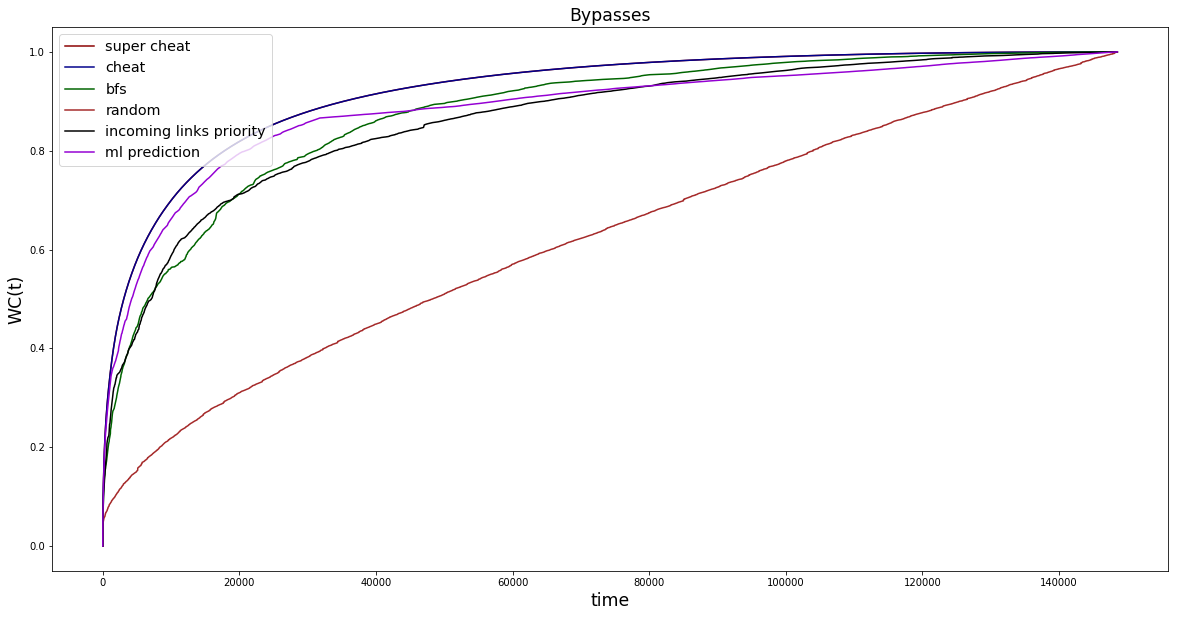

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,10))
plt.title('Bypasses', fontsize='xx-large')
plt.xlabel('time', fontsize='xx-large')
plt.ylabel('WC(t)', fontsize='xx-large')
plt.plot(np.arange(len(y_super_cheat)), y_super_cheat, label='super cheat', color = 'darkred')
plt.plot(np.arange(len(y_cheat)), y_cheat, label='cheat', color = 'darkblue')
plt.plot(np.arange(len(y_bfs)), y_bfs, label='bfs', color = 'darkgreen')
plt.plot(np.arange(len(y_random)), y_random, label='random', color = 'brown')
plt.plot(np.arange(len(y_inc_links)), y_inc_links, label='incoming links priority', color = 'black')
plt.plot(np.arange(len(y_embedding)), y_embedding, label='ml prediction', color = 'darkviolet')
plt.legend(loc = 'upper left', fontsize='x-large')
plt.show()

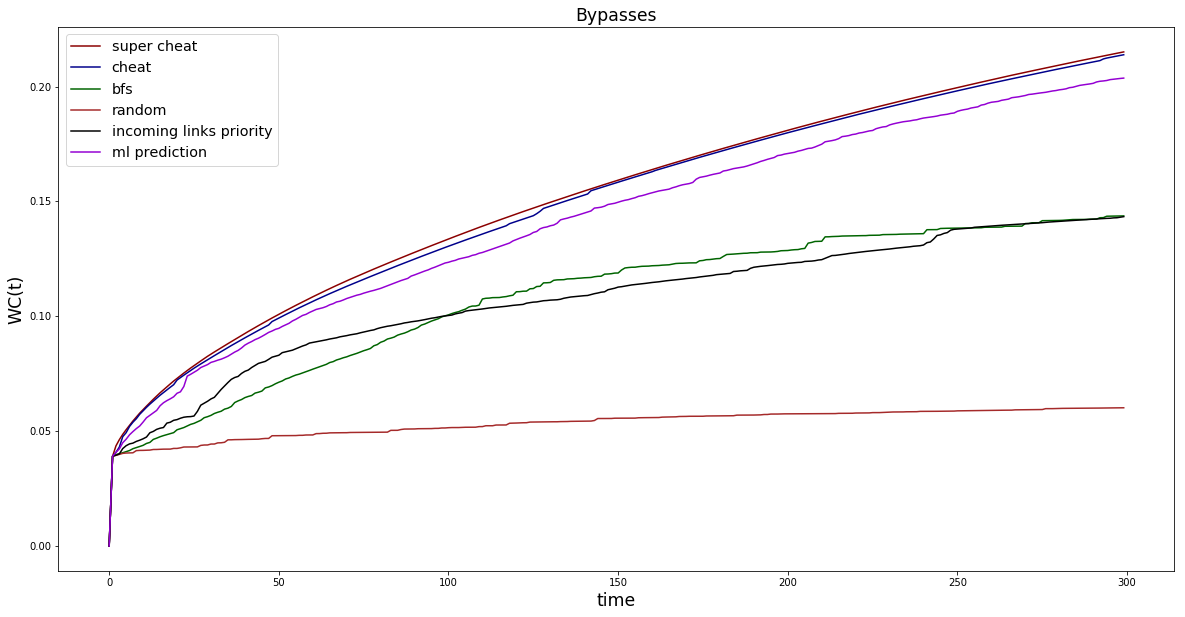

In [29]:
slicer = 300
plt.figure(figsize=(20,10))
plt.title('Bypasses', fontsize='xx-large')
plt.xlabel('time', fontsize='xx-large')
plt.ylabel('WC(t)', fontsize='xx-large')
plt.plot(np.arange(slicer), y_super_cheat[:slicer], label='super cheat', color = 'darkred')
plt.plot(np.arange(slicer), y_cheat[:slicer], label='cheat', color = 'darkblue')
plt.plot(np.arange(slicer), y_bfs[:slicer], label='bfs', color = 'darkgreen')
plt.plot(np.arange(slicer), y_random[:slicer], label='random', color = 'brown')
plt.plot(np.arange(slicer), y_inc_links[:slicer], label='incoming links priority', color = 'black')
plt.plot(np.arange(slicer), y_embedding[:slicer], label='ml prediction', color = 'darkviolet')
plt.legend(loc = 'upper left', fontsize='x-large')
plt.show()